In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import os, re
import matplotlib.colors as mcolors
import csv

def find_closest(value, series):
    return series.iloc[(series - value).abs().argsort()[:1]].values[0]

### Plot REF Fe (10 um)

002_S7-NiFe-6Sm_Activation_1
003_S7-NiFe-6Sm_Reaction_2
004_S7-NiFe-6Sm_PM_RT_1
S7-FeNi-6Sm_Activation_ramp_2


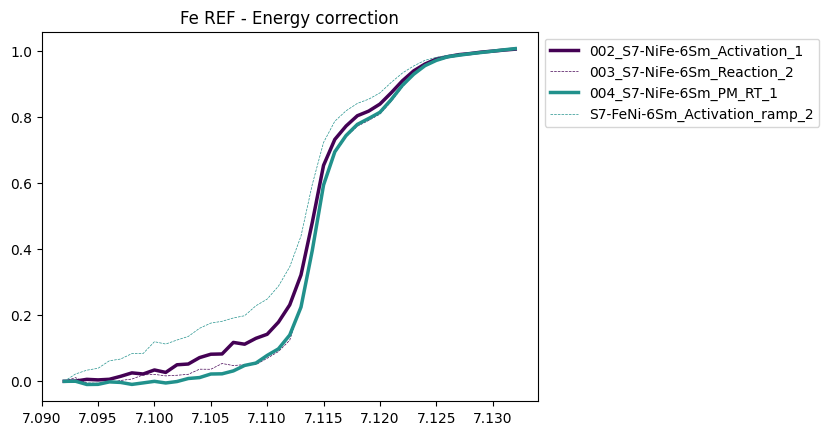

In [3]:
search_string = "Fe_REF_merged"
var1="ionch1" # diode1 / roiX
var2="mcaRt" # AS_IC / mcaLt

monoE_min = 7.08
monoE_max = 7.13
edge = 7.112
# Fe K-edge is at 7.112 KeV

labeled_files= []
for root, dirs, files in os.walk("."):
    files.sort() 
    for i, file in enumerate(files):
        if search_string in file:
            subfolder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            label = f"{subfolder_name}_{i % 2 +1}"
            labeled_files.append((file_path, label))
labeled_files.sort()

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=len(labeled_files) / 2)
energ_calib_Cu_REF_list = []
for idx, (file_path, label) in enumerate(labeled_files):
    print (label)
    result_df = pd.read_csv(file_path)

    closest_monoE1 = find_closest(monoE_min, result_df['monoE'])
    closest_monoE2 = find_closest(monoE_max, result_df['monoE'])
    signal_min = result_df.loc[result_df['monoE'] == closest_monoE1, f'{var1}/{var2}_mean'].values[0]
    signal_max = result_df.loc[result_df['monoE'] == closest_monoE2, f'{var1}/{var2}_mean'].values[0]
    color = cmap(norm(idx//2))  # Use the same color for pairs

    x = result_df['monoE']
    result_df["I_norm"]=(result_df[f'{var1}/{var2}_mean'] - signal_min)/(signal_max - signal_min)
    y = -0.0*idx + (result_df["I_norm"])
    err = (result_df[f'{var1}/{var2}_std'] - signal_min)/(signal_max - signal_min)

    target_value = 0.5
    idx_before = result_df[result_df["I_norm"] <= target_value].index[-1]
    idx_after = result_df[result_df["I_norm"] > target_value].index[0]
    x0, y0 = result_df.loc[idx_before, "I_norm"], result_df.loc[idx_before, 'monoE']
    x1, y1 = result_df.loc[idx_after, "I_norm"], result_df.loc[idx_after, 'monoE']
    interpolated_monoE = y0 + (target_value - x0) * (y1 - y0) / (x1 - x0)
    energ_calib_Cu_REF_list.append((label,interpolated_monoE))


    if label.endswith('_1'):
        plt.plot(x, y, label=label, linewidth=2.5, color=color)
    elif label.endswith('_2'):
        plt.plot(x, y, color=color, linestyle='--', linewidth=0.5, label=label)
    #plt.fill_between(x, y - err,y + err, color=color, alpha=0.2)
#plt.ylim([1.75,2.93])
#plt.xlim([7.15,9.])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Fe REF - Energy correction")

plt.savefig('Fe_REF_NEXAFS.png')

002_S7-NiFe-6Sm_Activation_1: has the edge at 7.1141, the energy shift is -0.002
003_S7-NiFe-6Sm_Reaction_2: has the edge at 7.1145, the energy shift is -0.003
004_S7-NiFe-6Sm_PM_RT_1: has the edge at 7.1145, the energy shift is -0.003
S7-FeNi-6Sm_Activation_ramp_2: has the edge at 7.1134, the energy shift is -0.001


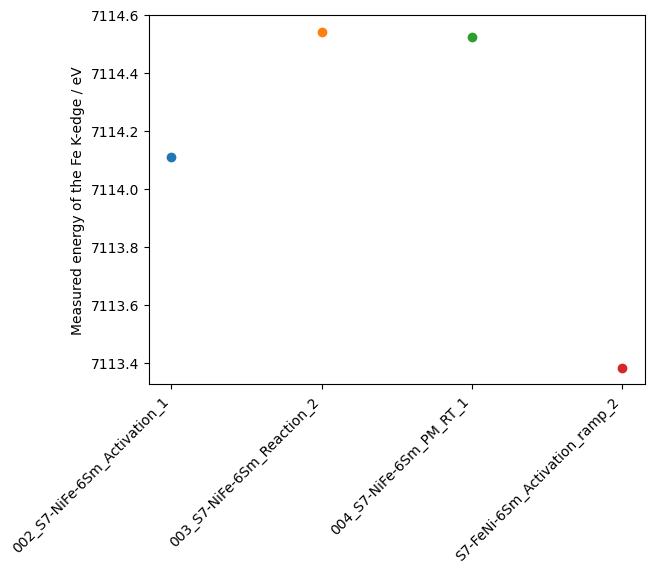

In [4]:
for (lab, en) in energ_calib_Cu_REF_list:
    plt.scatter(lab, en*1000)
    print(f"{lab}: has the edge at {en:.4f}, the energy shift is {edge-en:.3f}")
plt.xticks(rotation=45, ha='right')
plt.ylabel ("Measured energy of the Fe K-edge / eV")
plt.savefig('Fe_REF_energy_shift.png')

### Plot Cu K-edge EXAFS

001_Cu-6Sm_Pristine_RT_2
003_Cu-6Sm_Activation_dwell_1
003_Cu-6Sm_Activation_dwell_2
005_Cu-6Sm_Reaction_T1_1
005_Cu-6Sm_Reaction_T1_2
007_Cu-6Sm_Reaction_T2_1
007_Cu-6Sm_Reaction_T2_2
009_Cu-6Sm_Reaction_T3_1
009_Cu-6Sm_Reaction_T3_2
011_Cu-6Sm_Reaction_T4_1
011_Cu-6Sm_Reaction_T4_2
013_Cu-6Sm_Reaction_T5_1
013_Cu-6Sm_Reaction_T5_2
015_Cu-6Sm_PM_RT_1


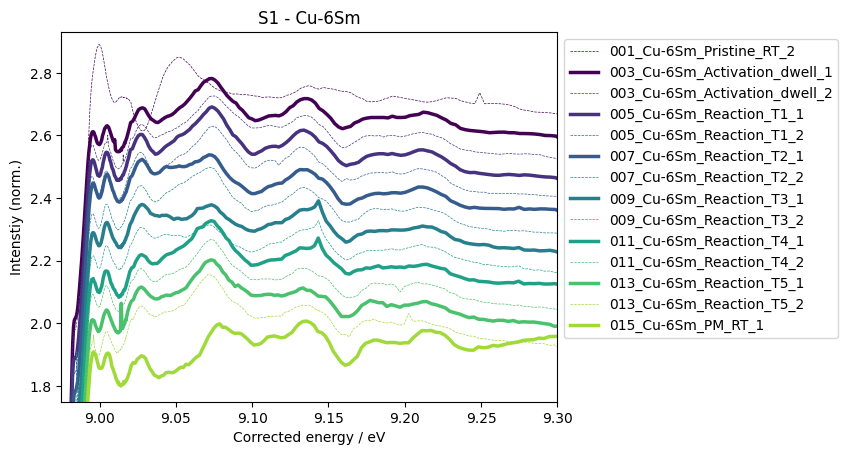

In [76]:
search_string = "Cu_K_EXAFS_merged"
var1="diode1"
var2="AS_IC"
monoE_min = 8.95
monoE_max = 9.2

labeled_files= []
for root, dirs, files in os.walk("."):
    files.sort() 
    for i, file in enumerate(files):
        if search_string in file:
            subfolder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            label = f"{subfolder_name}_{i % 2 + 1}"
            labeled_files.append((file_path, label))
labeled_files.sort()

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=len(labeled_files) / 2)
for idx, (file_path, label) in enumerate(labeled_files):
    print (label)
    result_df = pd.read_csv(file_path)

    closest_monoE1 = find_closest(monoE_min, result_df['monoE'])
    closest_monoE2 = find_closest(monoE_max, result_df['monoE'])

    signal_min = result_df.loc[result_df['monoE'] == closest_monoE1, f'{var1}/{var2}_mean'].values[0]
    signal_max = result_df.loc[result_df['monoE'] == closest_monoE2, f'{var1}/{var2}_mean'].values[0]

    color = cmap(norm(idx // 2))  # Use the same color for pairs

    deltaE = idx*1e-3/len(labeled_files)
    x = -deltaE + result_df['monoE']
    y = -0.06*idx + np.exp((result_df[f'{var1}/{var2}_mean'] - signal_min)/(signal_max - signal_min))
    err = (result_df[f'{var1}/{var2}_std'] - signal_min)/(signal_max - signal_min)

    if label.endswith('_1'):
        plt.plot(x, y, label=label, linewidth=2.5, color=color)
    elif label.endswith('_2'):
        plt.plot(x, y, color=color, linestyle='--', linewidth=0.5, label=label)
    #plt.fill_between(x, y - err,y + err, color=color, alpha=0.2)
plt.ylim([1.75,2.93])
plt.xlim([8.975,9.3])
plt.xlabel ("Corrected energy / eV")
plt.ylabel ("Intenstiy (norm.)")
plt.title ("S1 - Cu-6Sm")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig('Cu_EXAFS_S1.png')

001_Cu-6Sm_Pristine_RT_2
003_Cu-6Sm_Activation_dwell_1
003_Cu-6Sm_Activation_dwell_2
005_Cu-6Sm_Reaction_T1_1
005_Cu-6Sm_Reaction_T1_2
007_Cu-6Sm_Reaction_T2_1
007_Cu-6Sm_Reaction_T2_2
009_Cu-6Sm_Reaction_T3_1
009_Cu-6Sm_Reaction_T3_2
011_Cu-6Sm_Reaction_T4_1
011_Cu-6Sm_Reaction_T4_2
013_Cu-6Sm_Reaction_T5_1
013_Cu-6Sm_Reaction_T5_2
015_Cu-6Sm_PM_RT_1


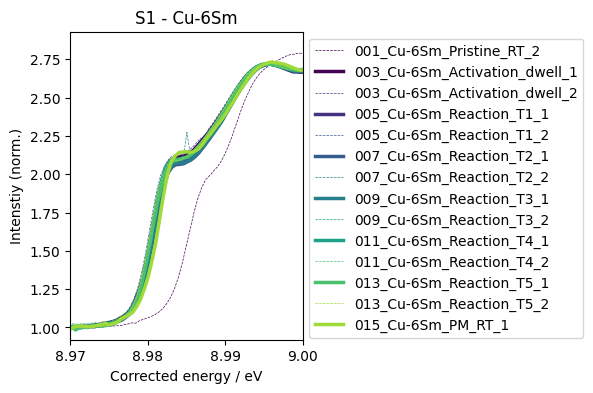

In [77]:
search_string = "Cu_K_EXAFS_merged"
var1="diode1"
var2="AS_IC"
monoE_min = 8.97
monoE_max = 8.996

labeled_files= []
for root, dirs, files in os.walk("."):
    files.sort() 
    for i, file in enumerate(files):
        if search_string in file:
            subfolder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            label = f"{subfolder_name}_{i % 2 + 1}"
            labeled_files.append((file_path, label))
labeled_files.sort()

plt.figure(figsize=(3, 4))
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=len(labeled_files) / 2)
for idx, (file_path, label) in enumerate(labeled_files):
    print (label)
    result_df = pd.read_csv(file_path)

    closest_monoE1 = find_closest(monoE_min, result_df['monoE'])
    closest_monoE2 = find_closest(monoE_max, result_df['monoE'])

    signal_min = result_df.loc[result_df['monoE'] == closest_monoE1, f'{var1}/{var2}_mean'].values[0]
    signal_max = result_df.loc[result_df['monoE'] == closest_monoE2, f'{var1}/{var2}_mean'].values[0]

    color = cmap(norm(idx // 2))  # Use the same color for pairs

    deltaE = idx*1e-3/len(labeled_files)
    x = -deltaE + result_df['monoE']
    y = -0.0*idx + np.exp((result_df[f'{var1}/{var2}_mean'] - signal_min)/(signal_max - signal_min))
    err = (result_df[f'{var1}/{var2}_std'] - signal_min)/(signal_max - signal_min)

    if label.endswith('_1'):
        plt.plot(x, y, label=label, linewidth=2.5, color=color)
    elif label.endswith('_2'):
        plt.plot(x, y, color=color, linestyle='--', linewidth=0.5, label=label)
    #plt.fill_between(x, y - err,y + err, color=color, alpha=0.2)
plt.ylim([0.92,2.93])
plt.xlim([8.97,9.0])
plt.xlabel ("Corrected energy / eV")
plt.ylabel ("Intenstiy (norm.)")
plt.title ("S1 - Cu-6Sm")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig('Cu_NEXAFS_S1.png')

### Plot Ce L3-edge NEXAFS

[('./001_Cu-6Sm_Pristine_RT/Data_Ce_L3_EXAFS_merged_scans_80_85.csv', '001_Cu-6Sm_Pristine_RT_2'), ('./003_Cu-6Sm_Activation_dwell/Data_Ce_L3_EXAFS_merged_scans_9_14.csv', '003_Cu-6Sm_Activation_dwell_2'), ('./005_Cu-6Sm_Reaction_T1/Data_Ce_L3_EXAFS_merged_scans_8_13.csv', '005_Cu-6Sm_Reaction_T1_2'), ('./007_Cu-6Sm_Reaction_T2/Data_Ce_L3_EXAFS_merged_scans_8_13.csv', '007_Cu-6Sm_Reaction_T2_2'), ('./009_Cu-6Sm_Reaction_T3/Data_Ce_L3_EXAFS_merged_scans_12_17.csv', '009_Cu-6Sm_Reaction_T3_2'), ('./011_Cu-6Sm_Reaction_T4/Data_Ce_L3_EXAFS_merged_scans_16_23.csv', '011_Cu-6Sm_Reaction_T4_2'), ('./013_Cu-6Sm_Reaction_T5/Data_Ce_L3_EXAFS_merged_scans_8_13.csv', '013_Cu-6Sm_Reaction_T5_2'), ('./015_Cu-6Sm_PM_RT/Data_Ce_L3_EXAFS_merged_scans_45_50.csv', '015_Cu-6Sm_PM_RT_2')]
001_Cu-6Sm_Pristine_RT_2
003_Cu-6Sm_Activation_dwell_2
005_Cu-6Sm_Reaction_T1_2
007_Cu-6Sm_Reaction_T2_2
009_Cu-6Sm_Reaction_T3_2
011_Cu-6Sm_Reaction_T4_2
013_Cu-6Sm_Reaction_T5_2
015_Cu-6Sm_PM_RT_2


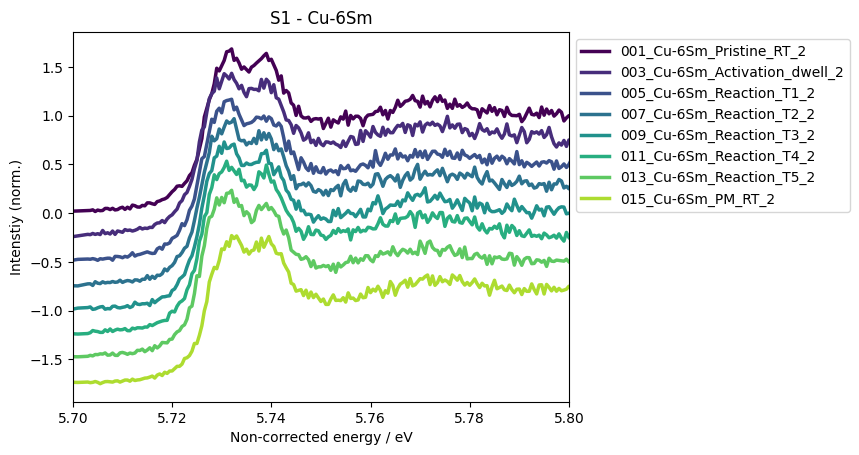

In [80]:
search_string = "Ce_L3_EXAFS_merged"
var1="roi1" # diode1
var2="mcaLt" # AS_IC
monoE_min = 5.68
monoE_max = 5.8

labeled_files= []
for root, dirs, files in os.walk("."):
    files.sort() 
    for i, file in enumerate(files):
        if search_string in file:
            subfolder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            label = f"{subfolder_name}_{i % 2 + 1}"
            labeled_files.append((file_path, label))
labeled_files.sort()
print (labeled_files)
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=len(labeled_files))
for idx, (file_path, label) in enumerate(labeled_files):
    print (label)
    result_df = pd.read_csv(file_path)

    closest_monoE1 = find_closest(monoE_min, result_df['monoE'])
    closest_monoE2 = find_closest(monoE_max, result_df['monoE'])

    signal_min = result_df.loc[result_df['monoE'] == closest_monoE1, f'{var1}/{var2}_mean'].values[0]
    signal_max = result_df.loc[result_df['monoE'] == closest_monoE2, f'{var1}/{var2}_mean'].values[0]

    color = cmap(norm(idx // 1))  # Use the same color for pairs

    x = result_df['monoE']
    y = -0.25*idx + ((result_df[f'{var1}/{var2}_mean'] - signal_min)/(signal_max - signal_min))
    err = (result_df[f'{var1}/{var2}_std'] - signal_min)/(signal_max - signal_min)

    if label.endswith('_2'):
        plt.plot(x, y, label=label, linewidth=2.5, color=color)
    elif label.endswith('_1'):
        plt.plot(x, y, color=color, linestyle='--', linewidth=1.5, label=label)
    #plt.fill_between(x, y - err,y + err, color=color, alpha=0.2)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.xlim([5.7,5.8])
plt.xlabel ("Non-corrected energy / eV")
plt.ylabel ("Intenstiy (norm.)")
plt.title ("S1 - Cu-6Sm")

plt.savefig('Ce_NEXAFS_S1.png')

### Plot Fe K-edge NEXAFS

In [3]:
search_string = "Fe_NEXAFS_merged"

energy_shifts = [-0.002, -0.003,-0.003,-0.001]

labeled_files= []
for root, dirs, files in os.walk("."):
    files.sort() 
    for i, file in enumerate(files):
        if search_string in file:
            subfolder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            label = f"{subfolder_name}_{i % 2 +1}"
            labeled_files.append((file_path, label))
labeled_files.sort()

for idx,(file_path, label) in enumerate(labeled_files):
    print (label)
    result_df = pd.read_csv(file_path)
    result_df["monoE"] = result_df["monoE"] + energy_shifts[idx]
    result_df.to_csv(file_path[:-4]+"_EC.dat")
    

002_S7-NiFe-6Sm_Activation_2
003_S7-NiFe-6Sm_Reaction_1
004_S7-NiFe-6Sm_PM_RT_2
S7-FeNi-6Sm_Activation_ramp_1


### Edge position of merged Fe NEXAFS

./002_S7-NiFe-6Sm_Activation/Data_Fe_NEXAFS_merged_scans_12_15_EC.dat
./003_S7-NiFe-6Sm_Reaction/Data_Fe_NEXAFS_merged_scans_10_13_EC.dat
./004_S7-NiFe-6Sm_PM_RT/Data_Fe_NEXAFS_merged_scans_2_3_EC.dat
./S7-FeNi-6Sm_Activation_ramp/Data_Fe_NEXAFS_merged_scans_19_20_EC.dat


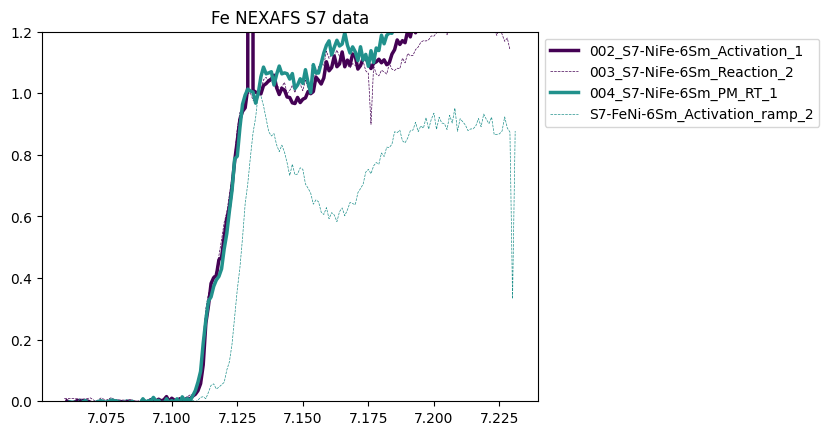

In [4]:
search_string = "Fe_NEXAFS_merged"
search_string_2 = "EC"
var1="roi5" # diode1 / roiX / ionch1
var2="mcaLt" # AS_IC / mcaLt mcaRt

monoE_min = 7.08
monoE_max = 7.133
#edge = 7.112
# Fe K-edge is at 7.112 KeV

labeled_files= []
for root, dirs, files in os.walk("."):
    files.sort() 
    for i, file in enumerate(files):
        if search_string in file and search_string_2 in file:
            subfolder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            label = f"{subfolder_name}_{i % 2 +1}"
            labeled_files.append((file_path, label))
labeled_files.sort()

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=len(labeled_files) / 2)
energ_calib_Fe_NEXAFS_list = []
for idx, (file_path, label) in enumerate(labeled_files):
    print (file_path)
    result_df = pd.read_csv(file_path)

    closest_monoE1 = find_closest(monoE_min, result_df['monoE'])
    closest_monoE2 = find_closest(monoE_max, result_df['monoE'])
    signal_min = result_df.loc[result_df['monoE'] == closest_monoE1, f'{var1}/{var2}_mean'].values[0]
    signal_max = result_df.loc[result_df['monoE'] == closest_monoE2, f'{var1}/{var2}_mean'].values[0]
    color = cmap(norm(idx//2))  # Use the same color for pairs

    x = result_df['monoE']
    result_df["I_norm"]=(result_df[f'{var1}/{var2}_mean'] - signal_min)/(signal_max - signal_min)
    y = -0.0*idx + (result_df["I_norm"])
    err = (result_df[f'{var1}/{var2}_std'] - signal_min)/(signal_max - signal_min)

    target_value = 0.5
    idx_before = result_df[result_df["I_norm"] <= target_value].index[-1]
    idx_after = result_df[result_df["I_norm"] > target_value].index[0]
    x0, y0 = result_df.loc[idx_before, "I_norm"], result_df.loc[idx_before, 'monoE']
    x1, y1 = result_df.loc[idx_after, "I_norm"], result_df.loc[idx_after, 'monoE']
    interpolated_monoE = y0 + (target_value - x0) * (y1 - y0) / (x1 - x0)
    energ_calib_Fe_NEXAFS_list.append((label,interpolated_monoE))


    if label.endswith('_1'):
        plt.plot(x, y, label=label, linewidth=2.5, color=color)
    elif label.endswith('_2'):
        plt.plot(x, y, color=color, linestyle='--', linewidth=0.5, label=label)
    #plt.fill_between(x, y - err,y + err, color=color, alpha=0.2)
plt.ylim([0,1.2])
#plt.xlim([7.15,9.])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Fe NEXAFS S7 data")

plt.savefig('Fe_NEXAFS_S7_data.png')


002_S7-NiFe-6Sm_Activation_1: has the edge at 7.1195
003_S7-NiFe-6Sm_Reaction_2: has the edge at 7.1185
004_S7-NiFe-6Sm_PM_RT_1: has the edge at 7.1201
S7-FeNi-6Sm_Activation_ramp_2: has the edge at 7.1429
Data has been written to S7-FeNi-6Sm_Fe_EC_position.dat


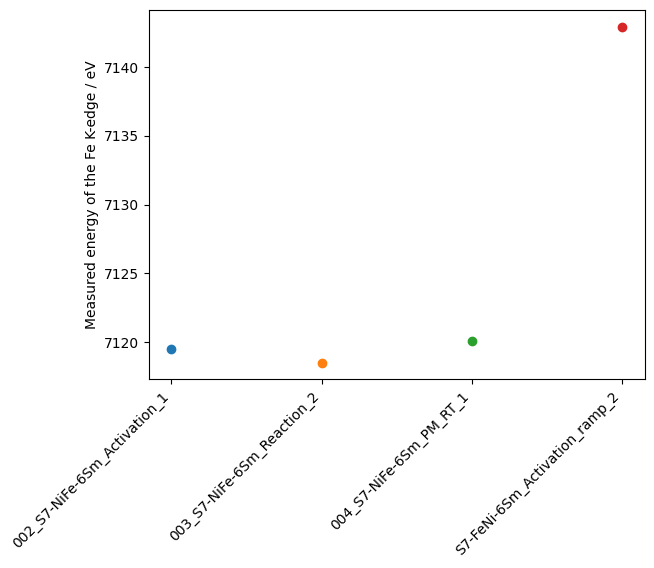

In [19]:
edge_position_list = []
sample_condition_list = []
for (lab, en) in energ_calib_Fe_NEXAFS_list:
    plt.scatter(lab, en*1000)
    print(f"{lab}: has the edge at {en:.4f}")
    edge_position_list.append(float(en))
    sample_condition_list.append(lab)

#print(sample_condition_list)    
#print(edge_position_list)
plt.xticks(rotation=45, ha='right')
plt.ylabel ("Measured energy of the Fe K-edge / eV")
#plt.savefig('Fe_REF_energy_shift.png')

#Save the edge data in a new file
filename = label.split('_')[0]+"_Fe_EC_position.dat"  #'sample_data.dat'
#print(filename)

# Writing to csv file
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Writing the headers
    writer.writerow(['Condition', 'Corrected_Edge'])
    
    # Writing the data rows
    for condition, edge in zip(sample_condition_list, edge_position_list):
        writer.writerow([condition, edge])

print(f"Data has been written to {filename}")




### Fe XAS Ref data- Extraction of the edge position 

./Fe_REF_XAS.dat
[('Fe foil', 7111.239375097091), ('Fe2O4', 7126.05676626845), ('Fe3O4', 7123.814528030327), ('FeO', 7121.044370293687), ('NiF2O4', 7125.4183902721625)]
Data saved to Fe_REF_XAS_position.dat


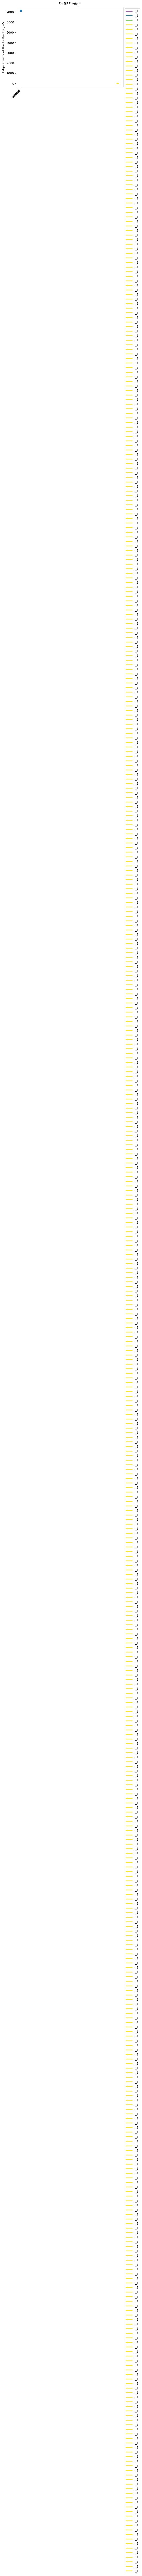

In [84]:
search_string = "Fe_REF_XAS.dat"

#edge = 7.112
# Fe K-edge is at 7.112 KeV

# Walk through the current directory and subdirectories
for root, dirs, files in os.walk("."):
    for i, file in enumerate(files):
        if search_string in file:
            file_path = os.path.join(root, file)
            label = f"{subfolder_name}_{i % 2 +1}"
            
print(file_path)
#print(label)

result_df = pd.read_csv(file_path, sep='\t')
#print(result_df.head(4))

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=(result_df.shape[1]-1) / 2)
energ_calib_Fe_REF_XAS_list = []

if 'Fe foil' in result_df.columns:
    for idx, value in enumerate(result_df['Fe foil']):
        monoE_min = 7099
        monoE_max = 7122

        closest_monoE1 = find_closest(monoE_min, result_df['Energy'])
        closest_monoE2 = find_closest(monoE_max, result_df['Energy'])
        signal_min = result_df.loc[result_df['Energy'] == closest_monoE1, 'Fe foil'].values[0]
        signal_max = result_df.loc[result_df['Energy'] == closest_monoE2, 'Fe foil'].values[0]
        color = cmap(norm(idx))  # Use the same color for pairs
    
        x = result_df['Energy']
        result_df["I"]=(result_df['Fe foil'] )
        y = -0.0*idx + (result_df["I"])
        #err = (result_df['Fe foil_std'] - signal_min)/(signal_max - signal_min)

        target_value = 0.5

        idx_before = result_df[result_df["I"] <= target_value].index[-1]
        idx_after = result_df[result_df["I"] > target_value].index[0]
        x0, y0 = result_df.loc[idx_before, "I"], result_df.loc[idx_before, 'Energy']
        x1, y1 = result_df.loc[idx_after, "I"], result_df.loc[idx_after, 'Energy']
        interpolated_monoE = y0 + (target_value - x0) * (y1 - y0) / (x1 - x0)
    energ_calib_Fe_REF_XAS_list.append(('Fe foil',float(interpolated_monoE)))

if  'Fe2O4' in result_df.columns:
    for idx, value in enumerate(result_df['Fe2O4']):
        monoE_min = 7104
        monoE_max = 7134

        closest_monoE1 = find_closest(monoE_min, result_df['Energy'])
        closest_monoE2 = find_closest(monoE_max, result_df['Energy'])
        signal_min = result_df.loc[result_df['Energy'] == closest_monoE1, 'Fe2O4'].values[0]
        signal_max = result_df.loc[result_df['Energy'] == closest_monoE2, 'Fe2O4'].values[0]
        color = cmap(norm(idx))  # Use the same color for pairs
    
        x = result_df['Energy']
        result_df["I"]=(result_df['Fe2O4'])
        y = -0.0*idx + (result_df["I"])
        #err = (result_df['Fe foil_std'] - signal_min)/(signal_max - signal_min)

        target_value = 0.75

        idx_before = result_df[result_df["I"] <= target_value].index[-1]
        idx_after = result_df[result_df["I"] > target_value].index[0]
        x0, y0 = result_df.loc[idx_before, "I"], result_df.loc[idx_before, 'Energy']
        x1, y1 = result_df.loc[idx_after, "I"], result_df.loc[idx_after, 'Energy']
        interpolated_monoE = y0 + (target_value - x0) * (y1 - y0) / (x1 - x0)
    energ_calib_Fe_REF_XAS_list.append(('Fe2O4',float(interpolated_monoE)))
   
if  'Fe3O4' in result_df.columns:
    for idx, value in enumerate(result_df['Fe3O4']):
        monoE_min = 7104
        monoE_max = 7134

        closest_monoE1 = find_closest(monoE_min, result_df['Energy'])
        closest_monoE2 = find_closest(monoE_max, result_df['Energy'])
        signal_min = result_df.loc[result_df['Energy'] == closest_monoE1, 'Fe3O4'].values[0]
        signal_max = result_df.loc[result_df['Energy'] == closest_monoE2, 'Fe3O4'].values[0]
        color = cmap(norm(idx))  # Use the same color for pairs
    
        x = result_df['Energy']
        result_df["I"]=(result_df['Fe3O4'])
        y = -0.0*idx + (result_df["I"])
        #err = (result_df['Fe foil_std'] - signal_min)/(signal_max - signal_min)

        target_value = 0.65

        idx_before = result_df[result_df["I"] <= target_value].index[-1]
        idx_after = result_df[result_df["I"] > target_value].index[0]
        x0, y0 = result_df.loc[idx_before, "I"], result_df.loc[idx_before, 'Energy']
        x1, y1 = result_df.loc[idx_after, "I"], result_df.loc[idx_after, 'Energy']
        interpolated_monoE = y0 + (target_value - x0) * (y1 - y0) / (x1 - x0)
    energ_calib_Fe_REF_XAS_list.append(('Fe3O4',float(interpolated_monoE)))

if  'FeO' in result_df.columns:
    for idx, value in enumerate(result_df['FeO']):
        monoE_min = 7104
        monoE_max = 7134

        closest_monoE1 = find_closest(monoE_min, result_df['Energy'])
        closest_monoE2 = find_closest(monoE_max, result_df['Energy'])
        signal_min = result_df.loc[result_df['Energy'] == closest_monoE1, 'FeO'].values[0]
        signal_max = result_df.loc[result_df['Energy'] == closest_monoE2, 'FeO'].values[0]
        color = cmap(norm(idx))  # Use the same color for pairs
    
        x = result_df['Energy']
        result_df["I"]=(result_df['FeO'])
        y = -0.0*idx + (result_df["I"])
        #err = (result_df['Fe foil_std'] - signal_min)/(signal_max - signal_min)

        target_value = 0.7

        idx_before = result_df[result_df["I"] <= target_value].index[-1]
        idx_after = result_df[result_df["I"] > target_value].index[0]
        x0, y0 = result_df.loc[idx_before, "I"], result_df.loc[idx_before, 'Energy']
        x1, y1 = result_df.loc[idx_after, "I"], result_df.loc[idx_after, 'Energy']
        interpolated_monoE = y0 + (target_value - x0) * (y1 - y0) / (x1 - x0)
    energ_calib_Fe_REF_XAS_list.append(('FeO',float(interpolated_monoE)))

if  'NiF2O4' in result_df.columns:
    for idx, value in enumerate(result_df['NiF2O4']):
        monoE_min = 7105
        monoE_max = 7132

        closest_monoE1 = find_closest(monoE_min, result_df['Energy'])
        closest_monoE2 = find_closest(monoE_max, result_df['Energy'])
        signal_min = result_df.loc[result_df['Energy'] == closest_monoE1, 'NiF2O4'].values[0]
        signal_max = result_df.loc[result_df['Energy'] == closest_monoE2, 'NiF2O4'].values[0]
        color = cmap(norm(idx))  # Use the same color for pairs
    
        x = result_df['Energy']
        result_df["I"]=result_df['NiF2O4'] 
        y = -0.0*idx + (result_df["I"])
        #err = (result_df['Fe foil_std'] - signal_min)/(signal_max - signal_min)

        target_value = 0.7

        idx_before = result_df[y <= target_value].index[-1]
        idx_after = result_df[y > target_value].index[0]
        x0, y0 = result_df.loc[idx_before, "I"], result_df.loc[idx_before, 'Energy']
        
        x1, y1 = result_df.loc[idx_after, "I"], result_df.loc[idx_after, 'Energy']
        interpolated_monoE = y0 + (target_value - x0) * (y1 - y0) / (x1 - x0)
        #print(interpolated_monoE)
        plt.plot(x, y, label=label, linewidth=2.5, color=color)
    energ_calib_Fe_REF_XAS_list.append(('NiF2O4',float(interpolated_monoE)))
print(energ_calib_Fe_REF_XAS_list)

#Save the edge data in a new file
filename = "Fe_REF_XAS_position.dat"  #'sample_data.dat'

# Open the file in write mode
with open(filename, 'w') as file:
    # Write each tuple in the data
    for condition, energy in energ_calib_Fe_REF_XAS_list:
        file.write(f'{condition},{energy}\n')

print(f'Data saved to {filename}')

## Plot is wrong
# Extract x and y values
x_labels = [item[0] for item in energ_calib_Fe_REF_XAS_list]
y_values = [item[1] for item in energ_calib_Fe_REF_XAS_list]

# Create a scatter plot
plt.scatter(x_labels, y_values)
plt.xticks(rotation=45, ha='right')
plt.ylabel ("Edge energy of the Fe K-edge / eV")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Fe REF edge")
plt.savefig('Fe_REF_XAS_edge.png')